In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import jj
from scipy.signal import argrelextrema

### Unsupervised Learning
This neural network now is occuring as a discretized version of a continuous system. While a discrete nature allows us to update weights at each step, this needs to be thought of as a continuous process.

The simplest way is to provide unsupervised learning to the neuron. This simply means that the neuron is going to learn not based off of a loss function, but rather by exposing the neurons to stimuli and having the weights change based on their reactions.

The typical model for this unsupervised learning is called Hebbian Learning. The basic principle behind it, which follows real neuron behaviour is as follows; An input neuron firing immediately before an output neuron strengthens the connection, whereas an output neuron firing immediately before an input neuron weakens the connection. This connection is represented by the weights as in the simple neural network, and I will demonstrate the strengthening of a connection by taking the connection notebook and applying Hebbian learning between the two neurons.

In [2]:
## Time domain set up
time = 1000 # Final Time
n = 20000 # Resolution
dt = time / n # A single time step length
tspan = np.arange(0, time, dt)  # time span
ispan = np.zeros_like(tspan)  # input current span

## First Neuron
phi_c = np.zeros_like(tspan)
v_c = np.zeros_like(tspan)

phi_p = np.zeros_like(tspan)
v_p = np.zeros_like(tspan)

flux = np.zeros_like(tspan)

## Second Neuron
phi_2c = np.zeros_like(tspan)
v_2c = np.zeros_like(tspan)

phi_2p = np.zeros_like(tspan)
v_2p = np.zeros_like(tspan)

flux2 = np.zeros_like(tspan)

## System Parameters
lmda = 0.1
gamma = 2.0
lmda_s = 0.5
lmda_p = 0.5
eta = 1
i_in = 0.3
i_b = 2.0

## Weight Parameters
w = 1
dw = 0
threshold = 0.4
last_fire = 0
A = 0.1 # Additive learning rate
B = 0.1 # Reductive learning rate
tau = 20 # Timescale of learning

## Synapse parameters
Q = 0.05
lmda_syn = 0.3
r12 = 1.4
omega = 1.0

## Define input current
ispan[int(np.size(ispan)/4):int(3*np.size(ispan)/4)] = i_in

In [9]:
## Initial Conditions, Nueron 1
phi_p[0] = 0
v_p[0] = 0
phi_c[0] = 0
v_c[0] = 0
flux[0] = lmda*(phi_p[0] * phi_c[0])
i_p = -lmda*(phi_c[0] + phi_p[0]) + lmda_s*ispan[0] + (1-lmda_p)*i_b
i_c = (-lmda*(phi_c[0] + phi_p[0]) + lmda_s*ispan[0] - lmda_p*i_b)/eta

## Initial Conditions, Synapse
i_o = 0
id_o = 0
v_o = 0
vd_o = 0

## Initial Conditions, Neuron 2
phi_2p[0] = 0
v_2p[0] = 0
phi_2c[0] = 0
v_2c[0] = 0
flux2[0] = lmda*(phi_2p[0] * phi_2c[0])
i_2p = -lmda*(phi_2c[0] + phi_2p[0]) + lmda_s*i_o + (1-lmda_p)*i_b
i_2c = (-lmda*(phi_2c[0] + phi_2p[0]) + lmda_s*i_o - lmda_p*i_b)/eta

### Changing Weight Function
Here I have already implemented the function as I described it in the jj.py file in both folders of the repositroy. The function is as follows:

$\partial w = Ae^{\frac{t_o - t_i}{\tau}}$ for $t_o - t_i > 0$
and
$\partial w = -Be^{\frac{t_i - t_o}{\tau}}$ for $t_o - t_i < 0$  
Here the learning rates are A and B, and represent how quickly you want changes to occur, and the learning can be skewed. The time difference is represented by output neuron time, $t_o$, and input neuron time, $t_i$. This is the basic form for this learning type, and my implementation could be improved by including a general funciton check rather than checking before and after each layer calculation.

In [4]:
oc = [i_o]  # Output Current to plot later
wspan = [1]
## Operate the Circuit
for j in range(np.size(tspan)-1):
    ## First Neuron
    phi_p[j+1], v_p[j+1] = jj.junction_step(phi_p[j], v_p[j], dt, gamma, i_p)
    phi_c[j+1], v_c[j+1] = jj.junction_step(phi_c[j], v_c[j], dt, gamma, i_c)
    [i_p, i_c] = jj.currents(lmda,phi_c[j+1],phi_p[j+1],lmda_s,ispan[j+1],lmda_p,i_b,eta)
    flux[j+1] = lmda*(phi_p[j+1]+phi_c[j+1])
    
    ## Check weights
    if (flux[j-1] < flux[j] > flux[j+1] and flux[j] > threshold):
        t0 = tspan[j]
        if last_fire == 1:
            w = w + jj.change_weights(A,B,tau,t1,t0)
            last_fire = 0
    
    wspan.append(w)
    
    ## Output to Second Neuron
    [v_o, vd_o, i_o, id_o] = jj.synapse_step(v_o, vd_o, i_o, id_o, v_p[j], v_2c[j], v_2p[j], gamma, omega, Q, lmda, lmda_syn, r12, dt)
    
    oc.append(w*i_o)
    
    ## Second Neuron
    phi_2p[j+1], v_2p[j+1] = jj.junction_step(phi_2p[j], v_2p[j], dt, gamma, i_2p)
    phi_2c[j+1], v_2c[j+1] = jj.junction_step(phi_2c[j], v_2c[j], dt, gamma, i_2c)
    
    [i_2p, i_2c] = jj.currents(lmda,phi_2c[j+1],phi_2p[j+1],lmda_s,w*i_o,lmda_p,i_b,eta)
    
    flux2[j+1] = lmda*(phi_2p[j+1]+phi_2c[j+1])
    
    ## Check weights
    if (flux2[j-1] < flux2[j] > flux2[j+1] and flux2[j] > threshold):
        t1 = tspan[j]
        if last_fire == 0:
            w = w + jj.change_weights(A,B,tau,t1,t0)
            last_fire = 1
    

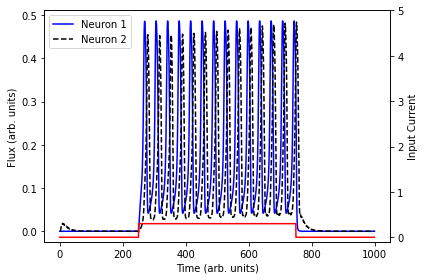

In [6]:
## Plotting
fig, ax1 = plt.subplots()

fig.patch.set_facecolor('white')

ax1.set_xlabel('Time (arb. units)')
ax1.set_ylabel('Flux (arb. units)')
ax1.plot(tspan,flux, 'b')
ax1.plot(tspan,flux2,'k--')
# ax1.set_xlim(50,250)
# ax1.set_ylim(-0.1,0.6)
ax1.legend(["Neuron 1","Neuron 2"],loc='upper left')

ax2 = ax1.twinx()
ax2.plot(tspan,ispan, 'r')
ax2.set_ylim(-0.1,5)
ax2.set_ylabel('Input Current')

fig.tight_layout()
plt.show()

This is the same as the connecting notebook, but with the connection slowly increasing over time from the learning. This is because the input is driving the other. The time domain was increased to 1000 form 300 to show behaviour over a longer time.

### Looking at current over time
Here we can see that the current input into the neuron increases over time as the weight increases at each spike. Any changes in frequencies are harder to detect, but the change is minimal in the time window.

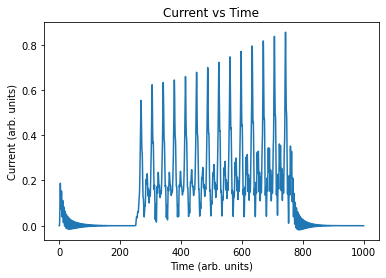

In [13]:
plt.plot(tspan,oc)
plt.title('Current vs Time')
plt.xlabel('Time (arb. units)')
plt.ylabel('Current (arb. units)')
plt.show()

### Weight Over Time
Next I plot the weight over time, you can see that the weight increases the moment the two spike occur. We can also see the weight decrease when the output spike is followed by the next input spike. The larger time difference between the output then input is why this decrease is smaller in magnitude than the increase. This behaviour over a long period of time is roughly linear, but with no upper limit to the weights or input current, there are obviously flaws in the implemenation of the code.

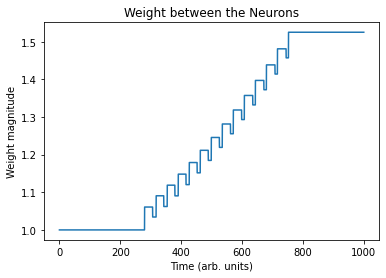

In [14]:
plt.plot(tspan, wspan)
plt.title('Weight between the Neurons')
plt.xlabel('Time (arb. units)')
plt.ylabel('Weight magnitude')
plt.show()